# Boostrapped OLS Analysis

Analyzing the relationship between the rolling z-scores and the returns spread. 

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from   scipy import stats

import statsmodels.api as sm
from   statsmodels.regression.rolling import RollingOLS

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FallenAngel\root\src")
from OLSAnalysis import OLSAnalysis

## Full Sample Parameters

In [3]:
def _get_beta(df: pd.DataFrame) -> pd.DataFrame:
    
    model = (sm.OLS(
        endog = df.signal_rtn,
        exog  = sm.add_constant(df.spread)).
        fit())
    
    df_val = (model.params.to_frame(
        name = "val").
        reset_index())
    
    df_pval = (model.pvalues.to_frame(
        name = "pval").
        reset_index())
    
    df_out = (df_val.merge(
        right = df_pval, how = "inner", on = ["index"]).
        rename(columns = {"index": "param"}))

    return df_out

def get_beta() -> pd.DataFrame: 
    
    df_out = (OLSAnalysis().get_signal().groupby(
        ["variable", "ticker_spread", "rtn_group"]).
        apply(_get_beta).
        reset_index().
        drop(columns = ["level_3"]))
    
    return df_out

df_beta = get_beta()

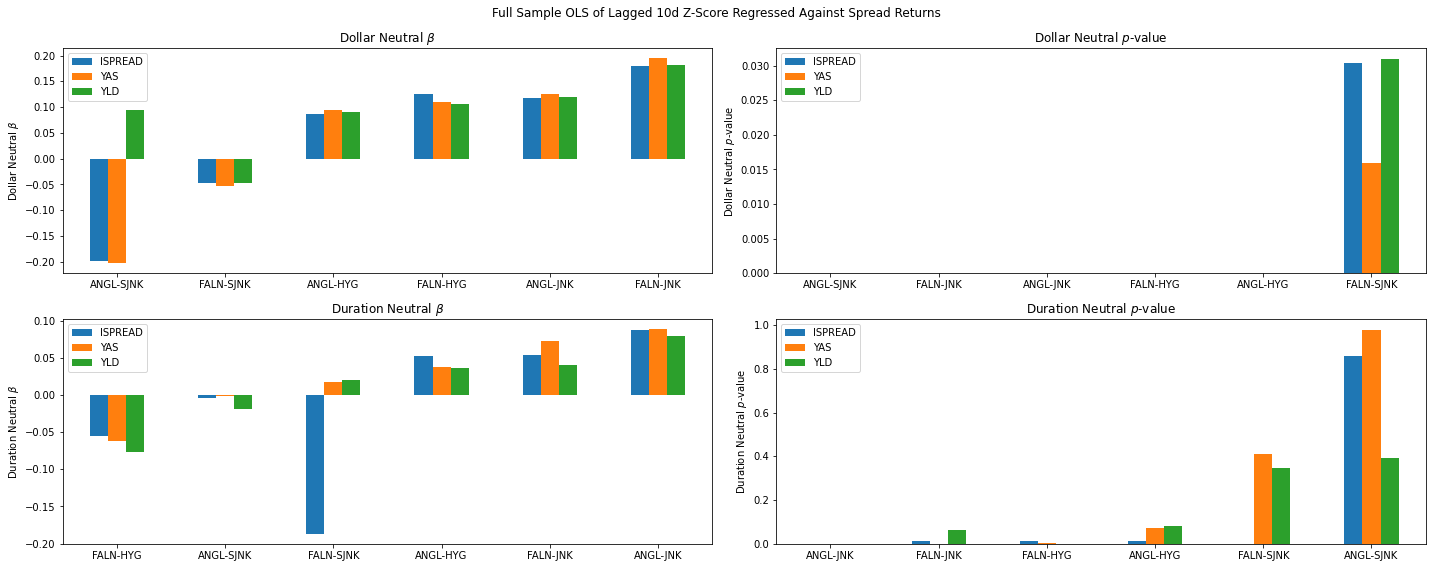

In [4]:
def plot_beta(df_beta: pd.DataFrame) -> plt.Figure: 
    
    df_longer = (df_beta.query(
        "param == 'spread'").
        drop(columns = ["param"]).
        rename(columns = {"variable": "yld_var"}).
        melt(id_vars = ["yld_var", "ticker_spread", "rtn_group"]).
        assign(
            ticker_spread = lambda x: x.ticker_spread.str.replace("_", "-"),
            rtn_group     = lambda x: x.rtn_group.str.split("_").str[0].str.capitalize() + " Neutral",
            variable      = lambda x: np.where(x.variable == "val", r"$\beta$", r"$p$-value"),
            group_var     = lambda x: x.rtn_group + " " + x.variable))

    group_vars = df_longer.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 2, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_longer.query(
            "group_var == @group_var").
            rename(columns = {"yld_var": ""}).
            pivot(index = "ticker_spread", columns = "", values = "value").
            sort_values("YAS").
            plot(
                ax     = ax,
                kind   = "bar",
                ylabel = group_var,
                title  = group_var,
                xlabel = "",
                rot    = 0))

    fig.suptitle("Full Sample OLS of Lagged 10d Z-Score Regressed Against Spread Returns")
    plt.tight_layout()
    
plot_beta(df_beta)

## Boostrapped Parameters

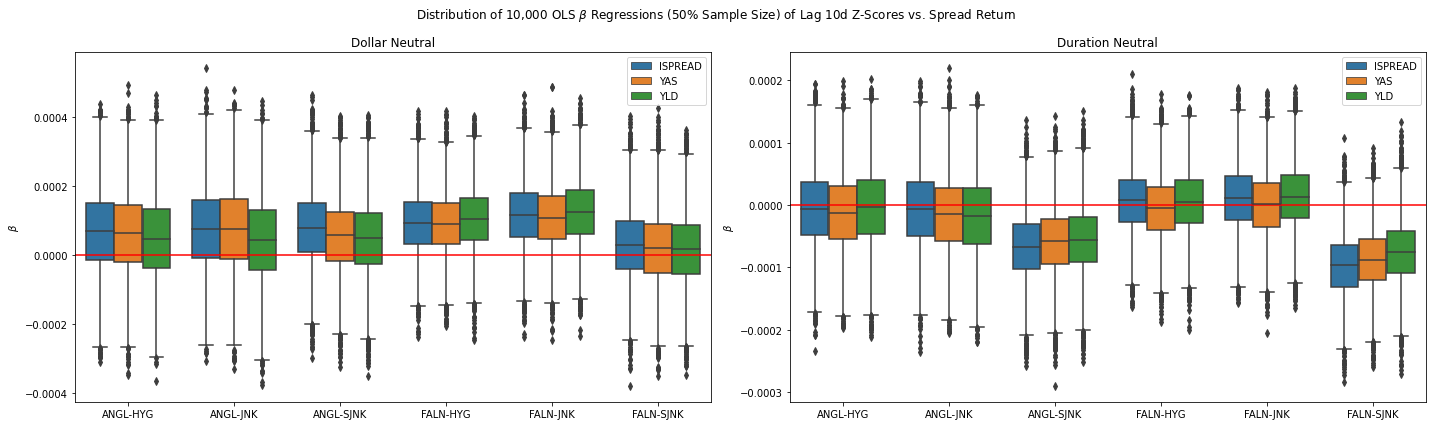

In [5]:
def plot_bootstrap_beta_distribution() -> plt.Figure: 
    
    renamer = {
        "dollar_neutral" : "Dollar Neutral",
        "duration_neutral": "Duration Neutral"}

    df         = OLSAnalysis().get_ols_samples()
    rtn_groups = df.rtn_group.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(rtn_groups), figsize = (20,6))

    for rtn_group, ax in zip(rtn_groups, axes.flatten()): 

        df_tmp = (df.query(
            "rtn_group == @rtn_group & param == 'lag_zscore'").
            rename(columns = {"variable": ""}).
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "-")))

        sns.boxplot(
            data = df_tmp,
            x    = "ticker_spread", 
            y    = "val", 
            hue  = "",
            ax   = ax)

        ax.axhline(y = 0, color = "red")
        ax.set_title(renamer[rtn_group])
        ax.set_xlabel("")
        ax.set_ylabel(r"$\beta$")

    fig.suptitle(r"Distribution of 10,000 OLS $\beta$ Regressions (50% Sample Size) of Lag 10d Z-Scores vs. Spread Return")
    plt.tight_layout()
    
plot_bootstrap_beta_distribution()

## Expanding Out of Sample Regression

In [6]:
def get_out_of_sample() -> pd.DataFrame: 

    df_plot = (OLSAnalysis().get_expanding_ols().assign(
        signal_rtn = lambda x: np.sign(x.lag_beta * x.lag_zscore) * x.spread))
    
    return df_plot

df_oos = get_out_of_sample()

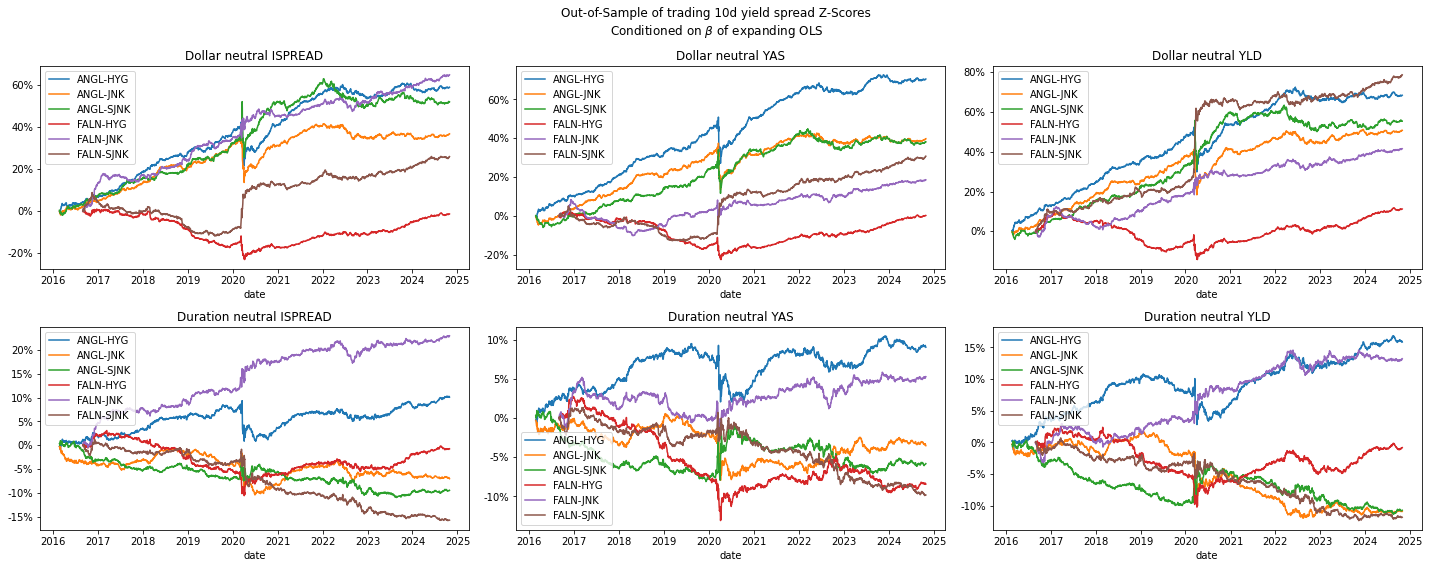

In [7]:
def plot_out_of_sample_rtn(df: pd.DataFrame) -> plt.Figure: 
    
    df_plot = (df.assign(
        group_var = lambda x: x.rtn_group.str.replace("_", " ").str.capitalize() + " " + x.variable))

    group_vars = df_plot.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_plot.query(
            "group_var == @group_var").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "-")).
            rename(columns = {"ticker_spread": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax = ax,
                title = group_var))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Out-of-Sample of trading 10d yield spread Z-Scores\n" + r"Conditioned on $\beta$ of expanding OLS")
    plt.tight_layout()
    
plot_out_of_sample_rtn(df_oos)

In [8]:
def get_sharpe(df_oos: pd.DataFrame) -> pd.DataFrame: 
    
    df_oos_sharpe = (df_oos[
        ["variable", "ticker_spread", "rtn_group", "signal_rtn"]].
        groupby(["variable", "ticker_spread", "rtn_group"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        drop(columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"sharpe": "oos_sharpe"}))

    df_is_sharpe = (OLSAnalysis().get_signal()[
        ["variable", "ticker_spread", "rtn_group", "signal_rtn"]].
        groupby(["variable", "ticker_spread", "rtn_group"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index().
        drop(columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"sharpe": "is_sharpe"}))

    df_sharpe = (df_oos_sharpe.merge(
        right = df_is_sharpe, 
        how   = "inner", 
        on    = ["variable", "ticker_spread", "rtn_group"]))
    
    return df_sharpe

df_sharpe = get_sharpe(df_oos)

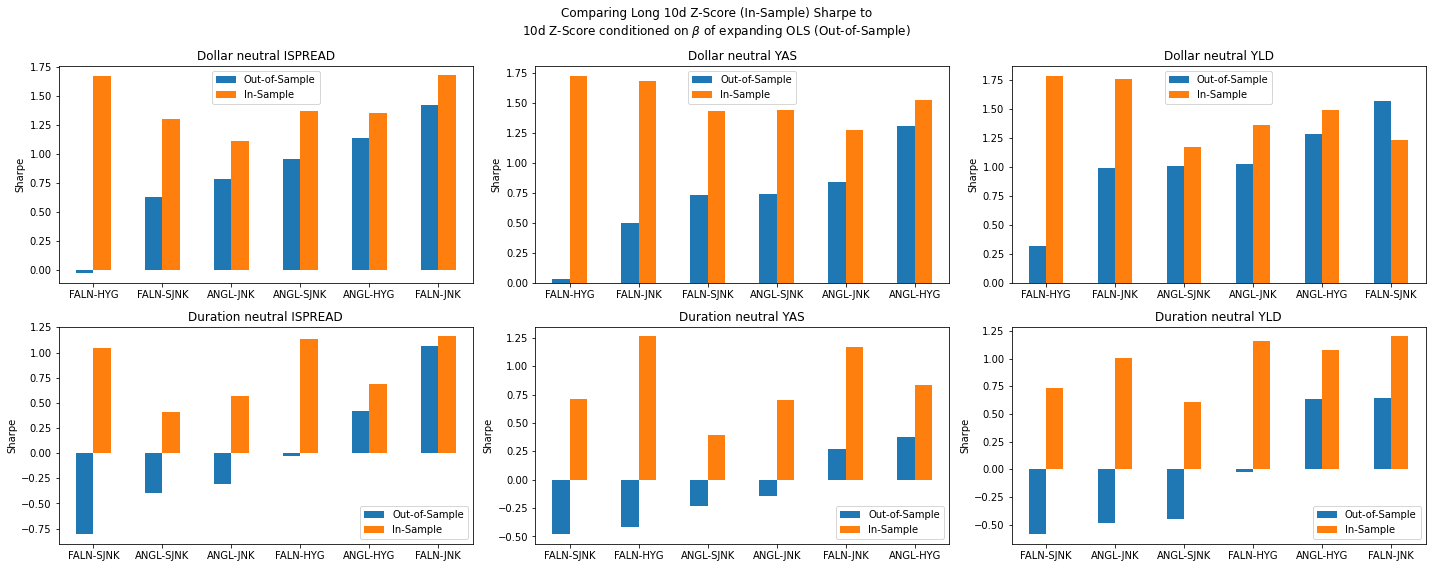

In [9]:
def plot_shapre_comparison(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    df_plot = (df_sharpe.assign(
        group_var = lambda x: x.rtn_group.str.replace("_", " ").str.capitalize() + " " + x.variable))

    group_vars = df_plot.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_plot.query(
            "group_var == @group_var").
            assign(ticker_spread = lambda x: x.ticker_spread.str.replace("_", "-")).
            set_index("ticker_spread")
            [["oos_sharpe", "is_sharpe"]].
            rename(columns = {
                "oos_sharpe": "Out-of-Sample",
                "is_sharpe" : "In-Sample"}).
            sort_values("Out-of-Sample").
            plot(
                kind   = "bar",
                ax     = ax,
                rot    = 0,
                xlabel = "",
                ylabel = "Sharpe",
                title  = group_var))

    fig.suptitle("Comparing Long 10d Z-Score (In-Sample) Sharpe to\n" + r"10d Z-Score conditioned on $\beta$ of expanding OLS (Out-of-Sample)")
    plt.tight_layout()
    
plot_shapre_comparison(df_sharpe)

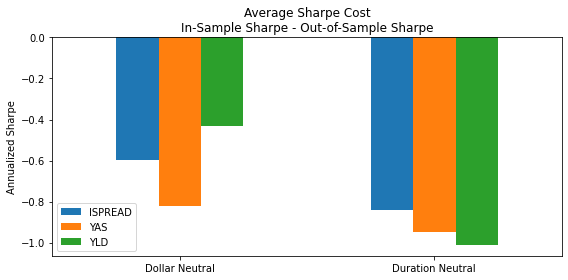

In [10]:
def plot_sharpe_loss(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    (df_sharpe.assign(
        sharpe_spread = lambda x: x.oos_sharpe - x.is_sharpe)
        [["variable", "rtn_group", "sharpe_spread"]].
        groupby(["variable", "rtn_group"]).
        agg("mean").
        reset_index().
        assign(rtn_group = lambda x: x.rtn_group.str.split("_").str[0].str.capitalize() + " Neutral").
        rename(columns = {"variable": ""}).
        pivot(index = "rtn_group", columns = "", values = "sharpe_spread").
        plot(
            figsize = (8,4),
            kind    = "bar",
            rot     = 0,
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            title   = "Average Sharpe Cost\nIn-Sample Sharpe - Out-of-Sample Sharpe"))

    plt.tight_layout()
    
plot_sharpe_loss(df_sharpe)

In [11]:
def get_out_of_sample_port(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df[
        ["date", "variable", "rtn_group", "signal_rtn"]].
        groupby(["date", "variable", "rtn_group"]).
        agg("mean").
        reset_index())
    
    return df_out

df_oos_port = get_out_of_sample_port(df_oos)

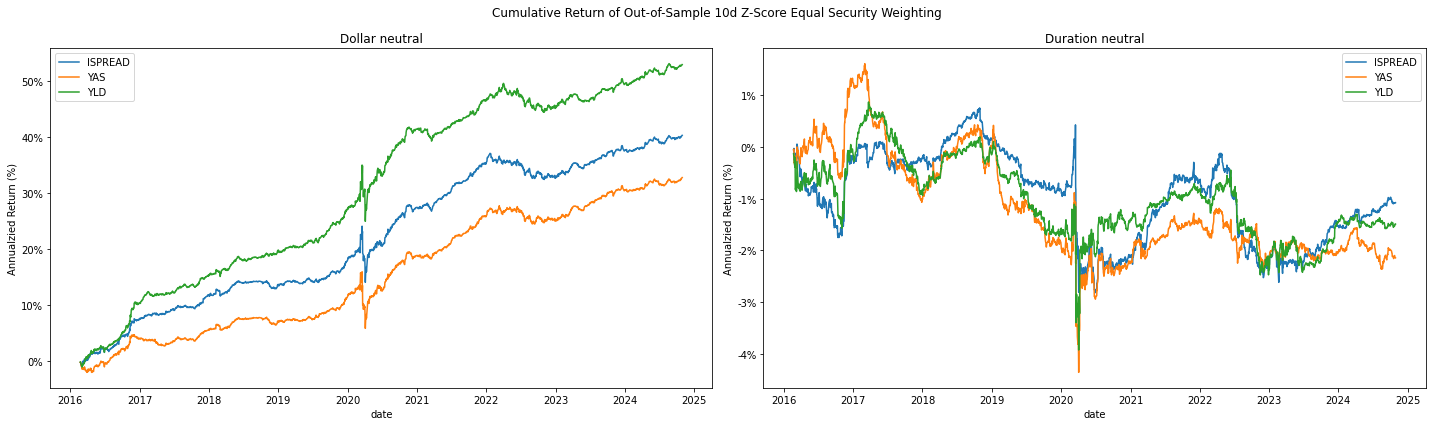

In [12]:
def plot_oos_rtn(df_oos_port: pd.DataFrame) -> plt.Figure: 
    
    group_vars = df_oos_port.rtn_group.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (20,6))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_oos_port.query(
            "rtn_group == @group_var").
            rename(columns = {"variable": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax = ax,
                ylabel = "Annualzied Return (%)",
                title  = group_var.replace("_", " ").capitalize()))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Cumulative Return of Out-of-Sample 10d Z-Score Equal Security Weighting")
    plt.tight_layout()
    
plot_oos_rtn(df_oos_port)

In [13]:
def get_port_sharpe(df_oos_port: pd.DataFrame) -> pd.DataFrame: 
    
    df_oos_sharpe = (df_oos_port.drop(
        columns = ["date"]).
        groupby(["variable", "rtn_group"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["variable", "rtn_group", "sharpe"]].
        rename(columns = {"sharpe": "oos_sharpe"}))

    df_sharpe = (OLSAnalysis().get_signal()[
        ["date", "variable", "rtn_group", "signal_rtn"]].
        groupby(["date", "variable", "rtn_group"]).
        agg("mean").
        reset_index().
        drop(columns = ["date"]).
        groupby(["variable", "rtn_group"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index()
        [["variable", "rtn_group", "sharpe"]].
        rename(columns = {"sharpe": "is_sharpe"}).
        merge(right = df_oos_sharpe, how = "inner", on = ["variable", "rtn_group"]))
    
    return df_sharpe

df_sharpe = get_port_sharpe(df_oos_port)

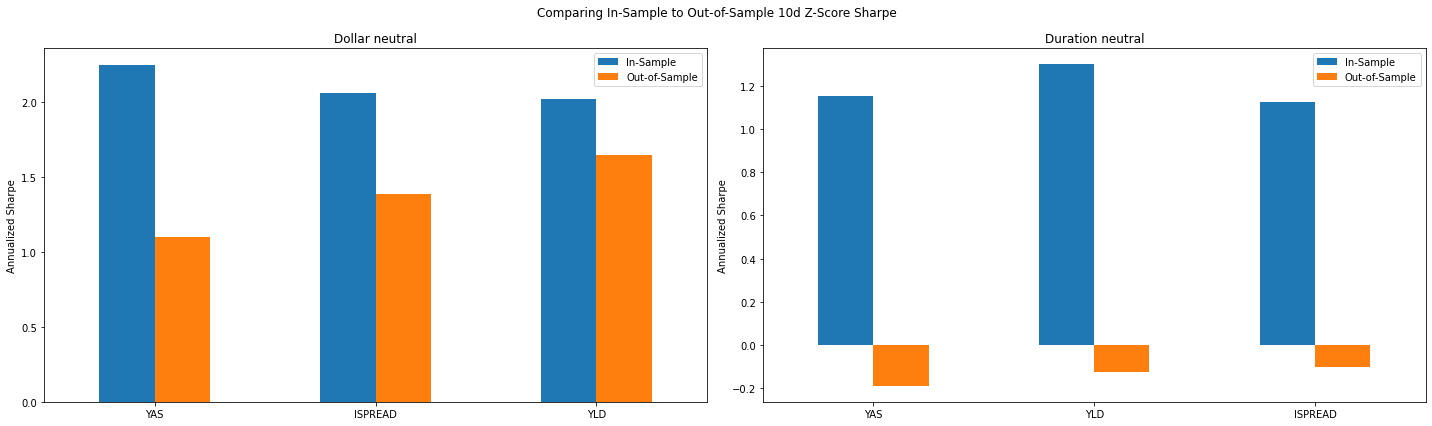

In [14]:
def plot_sharpe_comparison(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    variables = df_sharpe.rtn_group.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()): 

        (df_sharpe.query(
            "rtn_group == @variable").
            set_index("variable").
            drop(columns = ["rtn_group"]).
            sort_values("oos_sharpe").
            rename(columns = {
                "is_sharpe" : "In-Sample",
                "oos_sharpe": "Out-of-Sample"}).
            plot(
                kind   = "bar",
                ax     = ax,
                rot    = 0,
                xlabel = "",
                ylabel = "Annualized Sharpe",
                title  = variable.replace("_", " ").capitalize()))
        
    fig.suptitle("Comparing In-Sample to Out-of-Sample 10d Z-Score Sharpe")
    plt.tight_layout()
    
plot_sharpe_comparison(df_sharpe)

## Comparing Returns

In [15]:
def _get_spread_ttest(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.set_index(
        ["date", "port", "security"]))
    
    df_sharpe     = df_tmp.rolling(window = 30).mean() / df_tmp.rolling(window = 30).std() * np.sqrt(252)
    sharpe_spread = (df_sharpe.dropna().assign(
        sharpe_spread = lambda x: x.signal_rtn - x.sec_rtn).
        sharpe_spread)
    
    t_stat, p_value = stats.ttest_1samp(a = sharpe_spread, popmean = 0)
    data_dict       = {
        "t_stat": t_stat,
        "p_value": p_value,
        "mean_val": sharpe_spread.mean()}
    
    df_out = (pd.DataFrame.from_dict(
        data    = data_dict, 
        orient  = "index", 
        columns = ["pval"]))
    
    return df_out

def get_sharpe_spread(df_oos_port: pd.DataFrame) -> pd.DataFrame: 

    df_port = (df_oos_port.query(
        "rtn_group == 'dollar_neutral'").
        drop(columns = ["rtn_group"]).
        rename(columns = {"variable": "port"}))

    df_sec_rtn = (OLSAnalysis().get_raw_px().query(
        "security == ['LQD', 'JNK', 'ANGL']").
        pivot(index = "date", columns = "security", values = "PX").
        pct_change().
        reset_index().
        melt(id_vars = "date").
        dropna().
        rename(columns = {"value": "sec_rtn"}))

    df_out = (df_port.merge(
        right = df_sec_rtn, how = "inner", on = ["date"]).
        groupby(["port", "security"]).
        apply(_get_spread_ttest).
        reset_index().
        rename(columns = {"level_2": "param"}).
        pivot(index = ["port", "security"], columns = "param", values = "pval").
        reset_index().
        rename(columns = {
            "port"    : "Portfolio",
            "security": r"Benchmark ETF",
            "p_value" : r"$p$-value",
            "t_stat"  : r"$t$-stat",
            "mean_val": r"$\mu$ (ann)"}))
    
    return df_out

df_ttest = get_sharpe_spread(df_oos_port)

In [16]:
display(df_ttest)

param,Portfolio,Benchmark ETF,$\mu$ (ann),$p$-value,$t$-stat
0,ISPREAD,ANGL,0.597715,1.277256e-11,6.808113
1,ISPREAD,JNK,0.830484,3.250936e-22,9.799908
2,ISPREAD,LQD,1.440075,6.096371e-51,15.414814
3,YAS,ANGL,0.429060,8.109797e-06,4.473098
4,YAS,JNK,0.661830,4.299791e-13,7.290921
5,YAS,LQD,1.271420,2.265602e-37,13.021785
6,YLD,ANGL,0.965832,1.082327e-27,11.059033
7,YLD,JNK,1.198602,1.318320e-43,14.162518
8,YLD,LQD,1.808192,2.061532e-76,19.260804


In [17]:
def _get_rolling_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.set_index(
        "date").
        sort_index().
        assign(
            signal_rtn = lambda x: x.signal_rtn,
            sec_rtn    = lambda x: x.sec_rtn))
    
    df_out = (RollingOLS(
        endog  = df_tmp.signal_rtn,
        exog   = sm.add_constant(df_tmp.sec_rtn),
        window = 30).
        fit().
        params.
        rename(columns = {
            "const"  : "alpha",
            "sec_rtn": "beta"}).
        reset_index().
        melt(id_vars = "date").
        dropna())
    
    return df_out

def get_rolling_alpha(df_oos_port: pd.DataFrame) -> pd.DataFrame:

    df_port = (df_oos_port.query(
        "rtn_group == 'dollar_neutral'").
        drop(columns = ["rtn_group"]).
        rename(columns = {"variable": "port"}))

    df_sec_rtn = (OLSAnalysis().get_raw_px().query(
        "security == ['LQD', 'JNK', 'ANGL']").
        pivot(index = "date", columns = "security", values = "PX").
        pct_change().
        reset_index().
        melt(id_vars = "date").
        dropna().
        rename(columns = {"value": "sec_rtn"}))

    df_out = (df_port.merge(
        right = df_sec_rtn, how = "inner", on = ["date"]).
        groupby(["port", "security"]).
        apply(_get_rolling_ols).
        reset_index().
        drop(columns = ["level_2"]))
    
    return df_out

df_rolling_alpha = get_rolling_alpha(df_oos_port)

In [18]:
def _get_alpha_ttest(df: pd.DataFrame) -> pd.DataFrame: 
    
    t_stat, p_value = stats.ttest_1samp(a = df.value, popmean = 0)
    mean_alpha      = df.value.mean() * 100
    data_dict       = {
        "t_stat": t_stat,
        "p_value": p_value,
        "mean_val": mean_alpha}

    df_out = (pd.DataFrame.from_dict(
        data    = data_dict, 
        orient  = "index", 
        columns = ["pval"]))
    
    return df_out

def get_alpha_ttest(df_rolling_alpha: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_rolling_alpha.query(
        "variable == 'alpha'").
        drop(columns = ["variable"]).
        groupby(["security", "port"]).
        apply(_get_alpha_ttest).
        reset_index().
        rename(columns = {"level_2": "param"}).
        pivot(index = ["security", "port"], columns = "param", values = "pval").
        reset_index().
        rename(columns = {
            "port": "Portfolio",
            "security": "Benchmark",
            "mean_val": r"daily $\bar{\alpha}$ (%)",
            "p_value" : r"$p$-value",
            "t_stat" : r"$t$-test"}))
    
    return df_out

df_alpha_ttest = get_alpha_ttest(df_rolling_alpha)

In [19]:
display(df_alpha_ttest)

param,Benchmark,Portfolio,daily $\bar{\alpha}$ (%),$p$-value,$t$-test
0,ANGL,ISPREAD,0.013772,1.515722e-116,24.425882
1,ANGL,YAS,0.012362,8.029725e-84,20.277601
2,ANGL,YLD,0.017208,7.134300e-162,29.597021
3,JNK,ISPREAD,0.015252,2.521629e-144,27.651416
4,JNK,YAS,0.013562,4.062947e-109,23.523957
5,JNK,YLD,0.018714,7.654897e-187,32.277787
6,LQD,ISPREAD,0.015226,4.606503e-144,27.621934
7,LQD,YAS,0.012971,2.122473e-94,21.672591
8,LQD,YLD,0.018963,2.637580e-184,32.009269
